# MNIST images classification: validation and metric
1- Load the model  
2- Validation  
3- Confusison matrix  

## Include paths to our functions

In [10]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
   workingdir=str(pathlib.Path(workingdir).parents[0])
   print(workingdir)
   d=[d for d in os.listdir(str(workingdir))]
   n+=1
   if n>5:
       break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Setup librairies import and plots style

### Import librairies

In [11]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import seaborn as sns
import numpy as np
from glob import glob
#from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
#from skimage.segmentation import mark_boundaries
#from keras.models import load_model
import _pickle as cPickle
#import lime
#from lime import lime_image
from random import sample, randint, shuffle
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [12]:
tf.__version__

'1.12.0'

### Import our utils functions

In [13]:
import src.utils.mnist_utils as mnist_utils
import src.utils.tensorflow_helper as tensorflow_helper
import src.model_mnist_v1.trainer.model as mnist_v1

In [14]:
import importlib
importlib.reload(mnist_utils)
importlib.reload(mnist_v1)
importlib.reload(tensorflow_helper);# to reload the function and mask the output

### Set plots style

In [15]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [16]:
# color code: https://matplotlib.org/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py
plt.style.use('seaborn-ticks')

## Data visualization of some examples per classes

### Loading dataset

In [17]:
path_train='data/mnist/numpy_train/'
path_test='data/mnist/numpy_test/'
x_train=cPickle.load(open(path_train+'x_train.pkl', 'rb'))
y_train=cPickle.load(open(path_train+'y_train.pkl', 'rb'))
x_test=cPickle.load(open(path_test+'x_test.pkl', 'rb'))
y_test=cPickle.load(open(path_test+'y_test.pkl', 'rb'))

### Looking at some example from training dataset

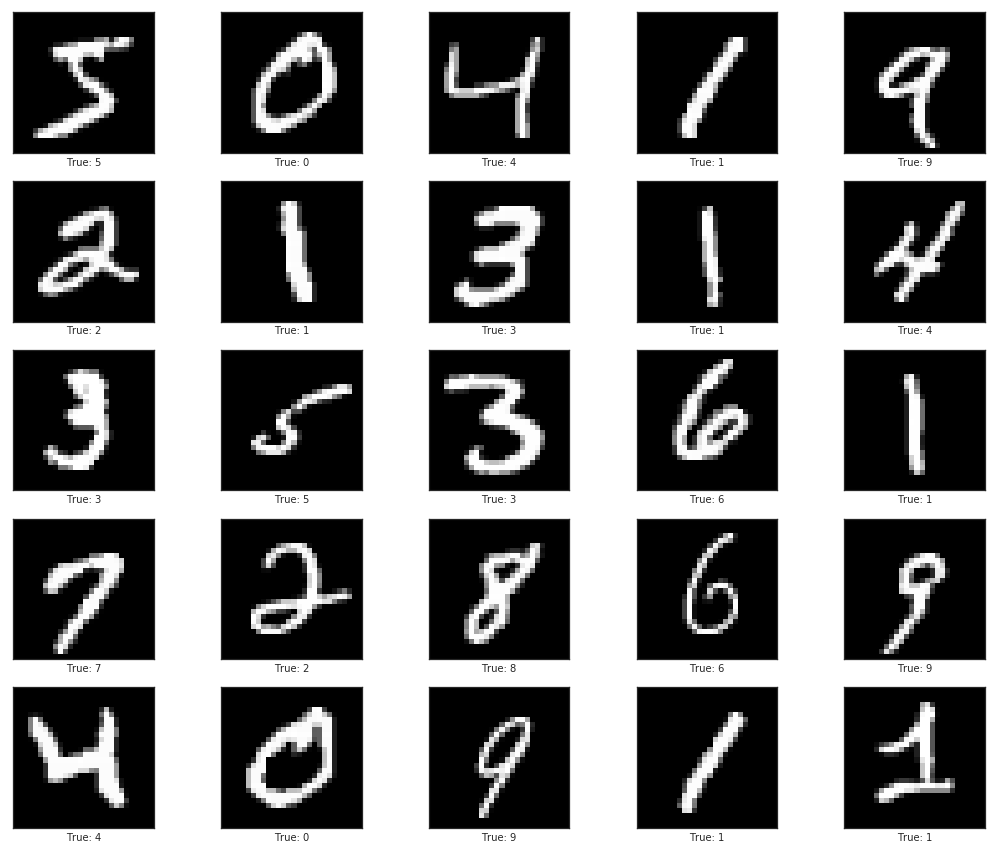

In [18]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

## Set parameter

In [20]:
tf.logging.set_verbosity(tf.logging.INFO)

In [21]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# model version
MODEL='v1'

## Defined flags

In [22]:
tensorflow_helper.del_all_flags(tf.flags.FLAGS)

In [23]:
# just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('f', '', 'kernel') 

# path to store the model and input for Tensorboard
tf.app.flags.DEFINE_string('model_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/ckpt/', 'Dir to save a model and checkpoints with keras')
tf.app.flags.DEFINE_string('tensorboard_dir_keras', './results/Models/Mnist/tf_1_12/keras/'+MODEL+'/logs/', 'Dir to save logs for TensorBoard with keras')

# parameters for the input dataset and train the model
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('step_per_epoch', len(x_train) // BATCH_SIZE, 'number of step per epoch')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')

# parameters for the model
tf.app.flags.DEFINE_integer('num_classes', NUM_CLASSES, 'number of classes in our model')
tf.app.flags.DEFINE_integer('dim_input', DIM_INPUT, 'dimension of the input data for our model')

FLAGS = tf.app.flags.FLAGS

## Load Model with the best validation accuracy

In [24]:
# best model
best_model=FLAGS.model_dir_keras+'keras_model.h5'

# load the weights with the best validation accuracy
best_model = tf.keras.models.load_model(best_model)

## Input dataset

### Input dataset functions for training

In [25]:
training_dataset = mnist_v1.input_mnist_array_dataset_fn(x_train, 
                                                         y_train, 
                                                         FLAGS,
                                                         mode=tf.estimator.ModeKeys.TRAIN, 
                                                         batch_size=FLAGS.batch_size)

INFO:tensorflow:input_dataset_fn: TRAIN, train


### Input dataset functions for testing

In [26]:
testing_dataset = mnist_v1.input_mnist_array_dataset_fn(x_test, 
                                                        y_test,
                                                        FLAGS,
                                                        mode=tf.estimator.ModeKeys.EVAL, 
                                                        batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: EVAL, eval


## Accuracy and losses

### Training dataset

In [32]:
# evaluate the model on test set
score = best_model.evaluate(training_dataset, 
                            steps=FLAGS.step_per_epoch,
                            verbose=1)

# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score[1]))

468/468 [==============================] - 4s 9ms/step
Loss:
  - loss [testing dataset]: 0.103

Accuracy:
  - accuracy [testing dataset]: 97.29%


### Test dataset

In [38]:
# evaluate the model on training set
score = best_model.evaluate(testing_dataset, 
                            steps=1,
                            verbose=1)

# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score[1]))

1/1 [==============================] - 1s 838ms/step
Loss:
  - loss [training dataset]: 0.167

Accuracy:
  - accuracy [training dataset]: 96.30%


In [43]:
score = best_model.test_on_batch(testing_dataset)

# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score[1]))

Loss:
  - loss [training dataset]: 0.167

Accuracy:
  - accuracy [training dataset]: 96.30%


### Predictions

In [47]:
pred = best_model.predict_on_batch(testing_dataset)

In [48]:
len(pred)

10000

In [50]:
pred = best_model.predict(testing_dataset,
                          steps=1)

In [51]:
len(pred)

10000

In [52]:
pred.shape

(10000, 10)

## Visualize predictions

In [53]:
y_hat = best_model.predict_on_batch(testing_dataset)

In [68]:
dict_label=['0',
            '1',
            '2',
            '3',
            '4',
            '5',
            '6',
            '7',
            '8',
            '9']

In [69]:
y_hat.shape

(10000, 10)

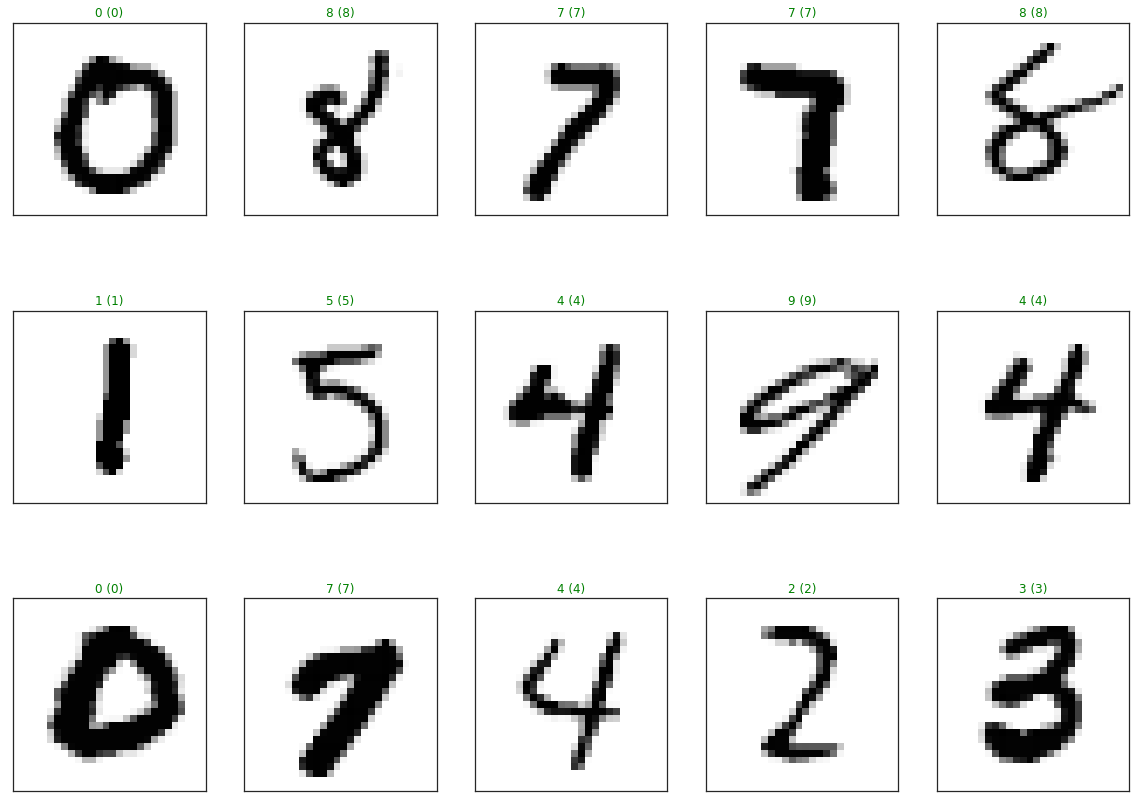

In [70]:
# plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = y_test[index] # no encoding
    # Set the title for each image
    ax.set_title("{} ({})".format(dict_label[predict_index], 
                                  dict_label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
iterator = testing_dataset.make_one_shot_iterator()
features, labels = iterator.get_next()
debug_info=False
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            if  debug_info:
                print(time.clock() - start_time, 'seconds')
                print(x.shape)
                print(y.shape)
                print('first label of the batch',np.argmax(y[0]),'\n')
            
            # we just need the full dataset so one epoch
            break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

## Metrics

<img src="img/metrics.png" width=600 align="left">

In [23]:
predict_index = np.argmax(y_hat, axis = 1)
true_index = np.argmax(y_test, axis = 1)

print(classification_report(true_index, predict_index, target_names=dict_label))

AxisError: axis 1 is out of bounds for array of dimension 1

## Confusion matrix
### Helper functions

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label');
    plt.xlabel('Predicted label');

### Simple confusion matrix

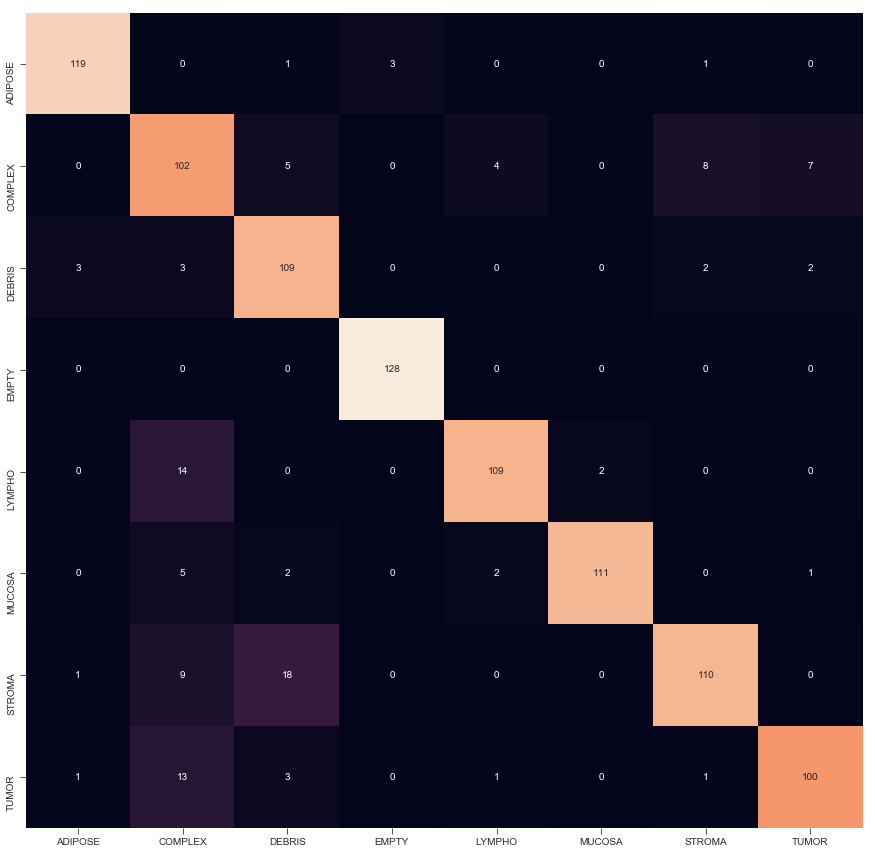

In [85]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(confusion_matrix(true_index, predict_index), 
            annot=True, cbar=False, fmt='d', ax=ax)
ax.set_yticklabels(dict_label, minor=False)
ax.set_xticklabels(dict_label, minor=False);

### Confusion matrix with more informations

In [56]:
# compute confusion matrix
cnf_matrix = confusion_matrix(true_index, predict_index)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[119   0   1   3   0   0   1   0]
 [  0 102   5   0   4   0   8   7]
 [  3   3 109   0   0   0   2   2]
 [  0   0   0 128   0   0   0   0]
 [  0  14   0   0 109   2   0   0]
 [  0   5   2   0   2 111   0   1]
 [  1   9  18   0   0   0 110   0]
 [  1  13   3   0   1   0   1 100]]


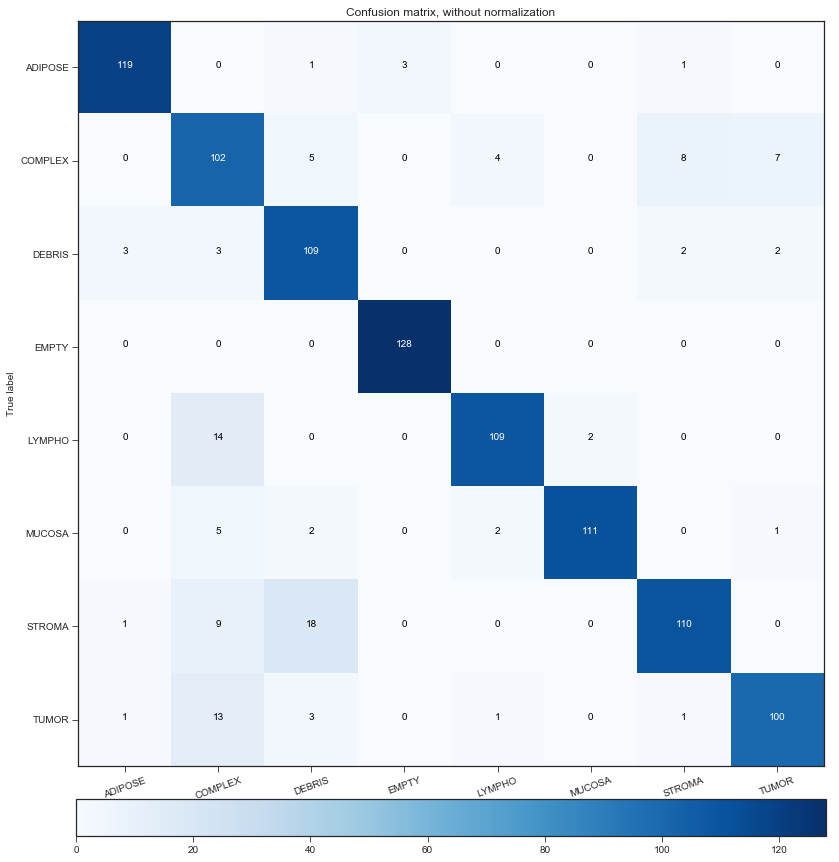

In [88]:
# plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.96 0.   0.01 0.02 0.   0.   0.01 0.  ]
 [0.   0.81 0.04 0.   0.03 0.   0.06 0.06]
 [0.03 0.03 0.92 0.   0.   0.   0.02 0.02]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.11 0.   0.   0.87 0.02 0.   0.  ]
 [0.   0.04 0.02 0.   0.02 0.92 0.   0.01]
 [0.01 0.07 0.13 0.   0.   0.   0.8  0.  ]
 [0.01 0.11 0.03 0.   0.01 0.   0.01 0.84]]


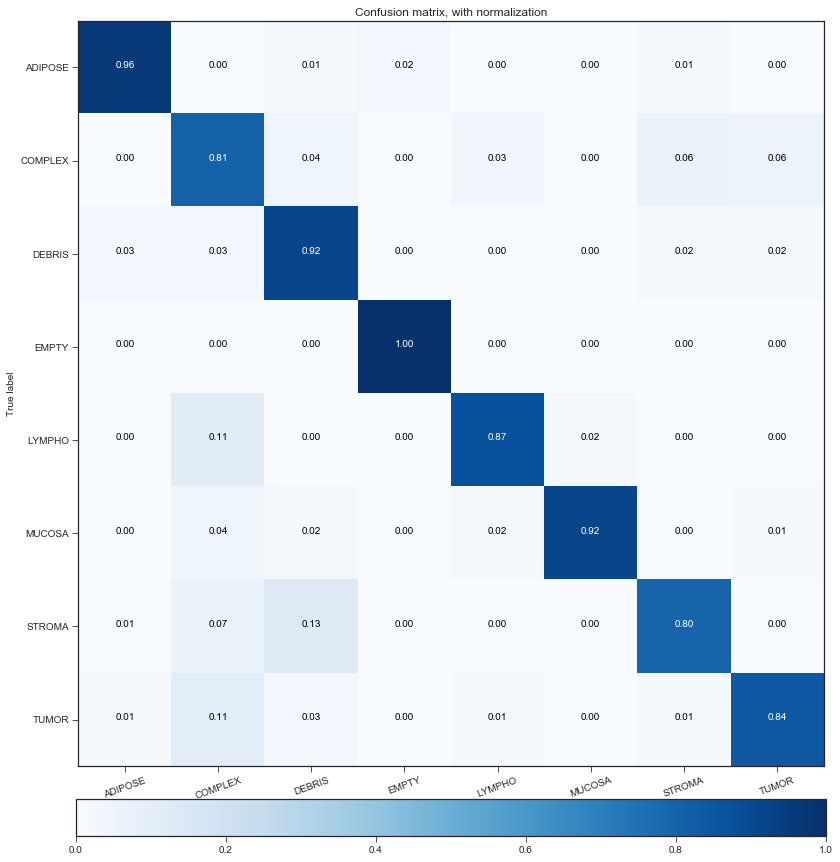

In [89]:
# plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,normalize=True,
                      title='Confusion matrix, with normalization')

## ROC curves

In [240]:
def roc_curves(y_test, y_score, dict_label):

    # plot configuration
    plt.figure(figsize=(10,8))
    plt.rcParams.update({'font.size': 15}) 
    lw = 2
    
    n_classes=len(dict_label)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # compute macro-average ROC curve and ROC area

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Ffnally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class')
    plt.legend(loc="best")
    plt.show()

    # plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['pink', 'purple', 'deeppink', 'lavenderblush', 'darkorchid', 'orchid', 'hotpink', 'darkslateblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve for {0} (area = {1:0.2f})'
                 ''.format(dict_label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class')
    plt.legend(loc="best",prop={'size': 13})
    plt.show()


    # zoom in view of the upper left corner.
    plt.figure(figsize=(10,8))
    plt.xlim(0, 0.4)
    plt.ylim(0.7, 1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['pink', 'purple', 'deeppink', 'lavenderblush', 'darkorchid', 'orchid', 'hotpink', 'darkslateblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve for {0} (area = {1:0.2f})'
                 ''.format(dict_label[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class')
    plt.legend(loc="best")
    plt.show()

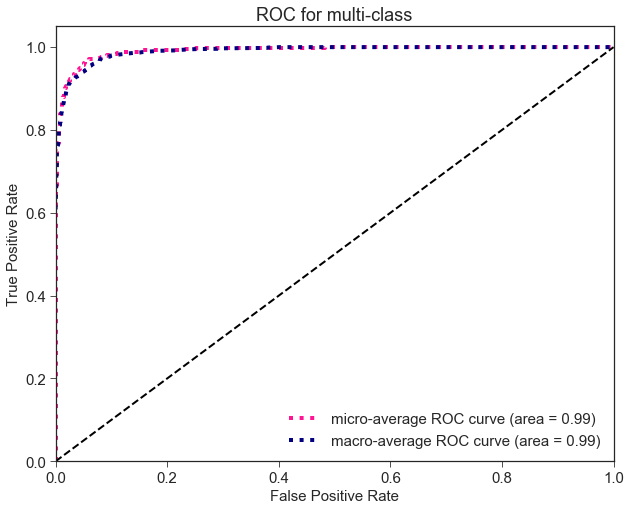

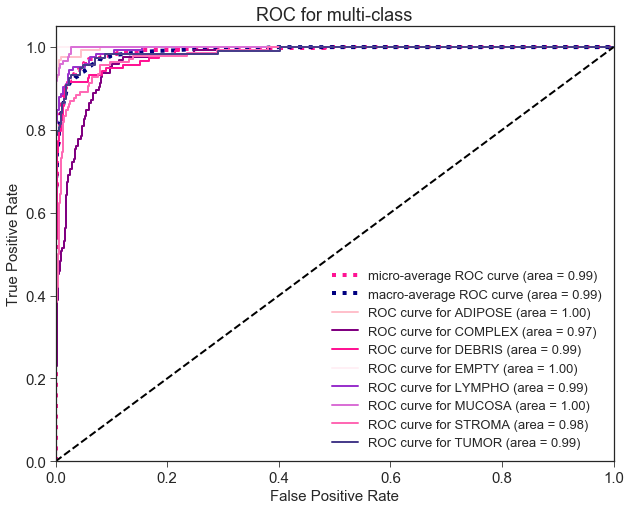

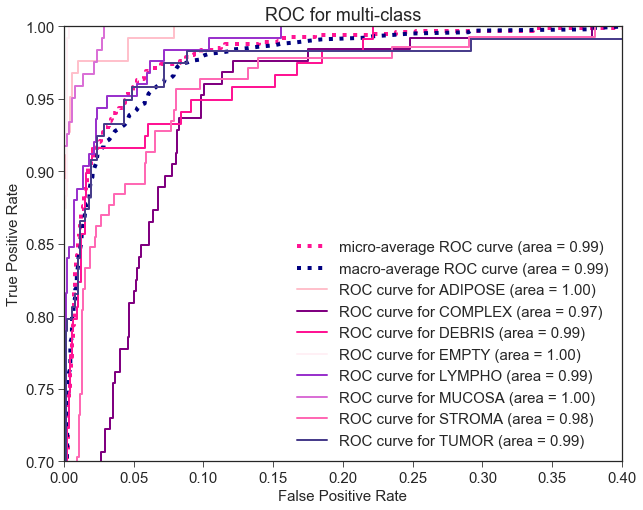

In [241]:
roc_curves(y_test, y_hat, dict_label)

## Model interpretation
### Helper functions

In [125]:
def evaluation_indices(y_pred, y_test):
    # function for getting correctly and incorrectly classified indices
    index = 0
    correctly_classified_indices = []
    misclassified_indices = []
    for label, predict in zip(y_test, y_pred):
        if label != predict: 
            misclassified_indices.append(index)
        else:
            correctly_classified_indices.append(index)
        index +=1
    return (correctly_classified_indices, misclassified_indices)

### Use LIME for correct classified classes

In [126]:
correctly_classified_indices, misclassified_indices = evaluation_indices(predict_index, true_index)

In [137]:
# inspecting class labels for future reference 
labels_index = {0 : 'ADIPOSE', 
                1 : 'COMPLEX',
                2 : 'DEBRIS',
                3 : 'EMPTY',
                4 : 'LYMPHO',
                5 : 'MUCOSA',
                6 : 'STROMA',
                7 : 'TUMOR'}

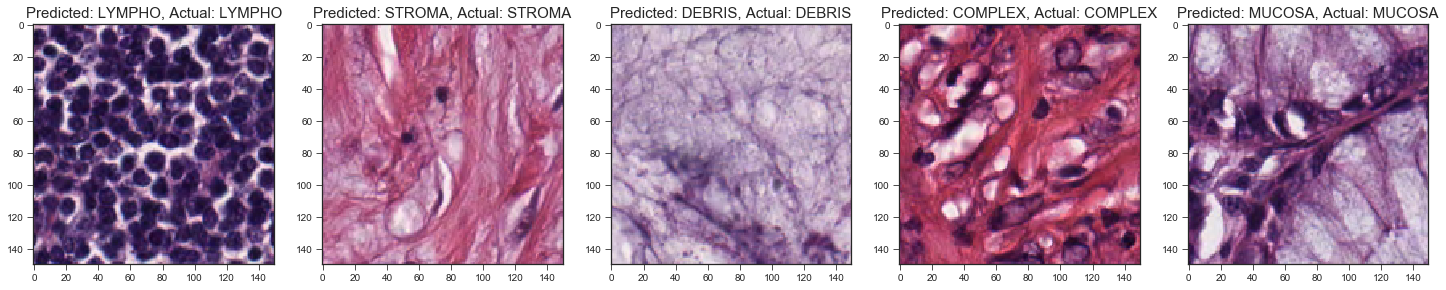

In [154]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(x_test[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[good_index]], 
                                                 labels_index[true_index[good_index]]), fontsize = 15)

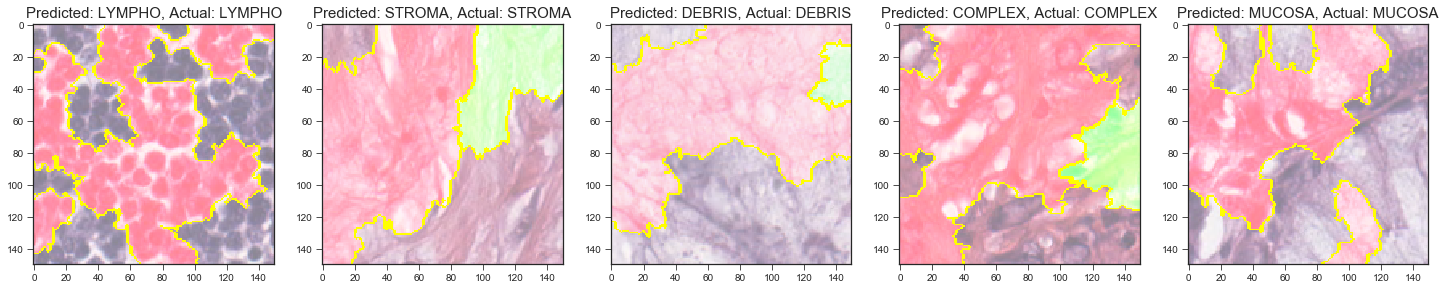

In [153]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate(correctly_classified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(x_test[good_index], best_model.predict, top_labels=8, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[good_index]], 
                                                 labels_index[true_index[good_index]]), fontsize = 15)
    

### Use LIME for incorrect classified classes

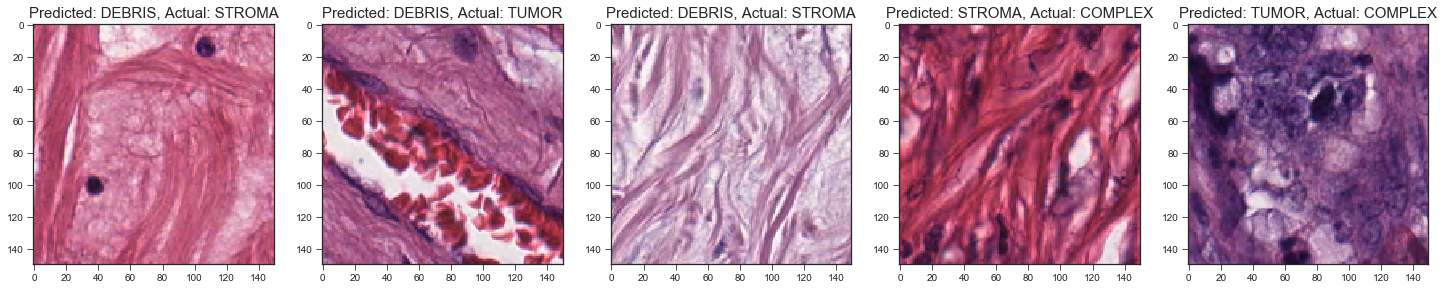

In [155]:
plt.figure(figsize=(25,5))
#shuffle(correctly_classified_indices)
for plot_index, good_index in enumerate( misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    plt.imshow(x_test[good_index])
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[good_index]], 
                                                 labels_index[true_index[good_index]]), fontsize = 15)

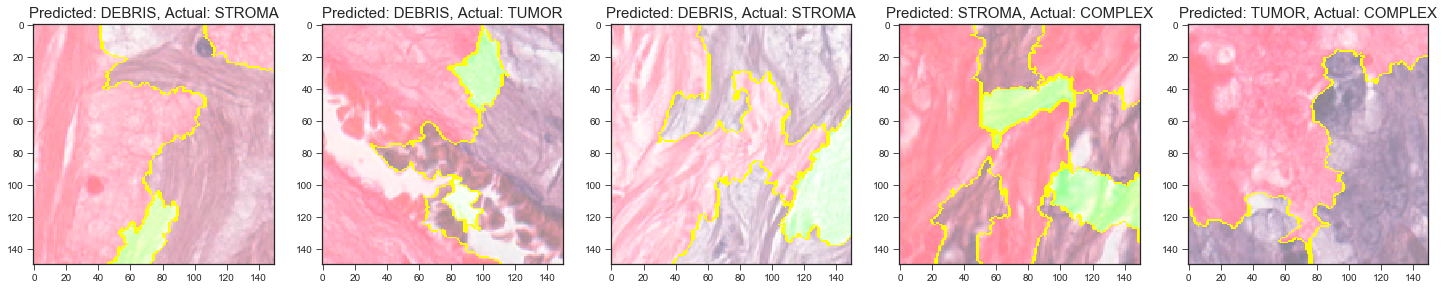

In [157]:
plt.figure(figsize=(25,5))
#shuffle(misclassified_indices)
for plot_index, bad_index in enumerate(misclassified_indices[0:5]):
    plt.subplot(1, 5, plot_index + 1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(x_test[bad_index], best_model.predict, top_labels=8, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=10, hide_rest=False)
    x = mark_boundaries(temp / 2 + 0.5, mask)
    plt.imshow(x, interpolation='none')
    plt.title('Predicted: {}, Actual: {}'.format(labels_index[predict_index[bad_index]], 
                                                 labels_index[true_index[bad_index]]), fontsize = 15)